# COMP7404 Computational Intelligence and Machine Learnin <br> Group Project: Boosted Random Foreset
 
Team Member:
```
Lee Kai Shing 3035562540
Mak Tak Hei 3035420273
Lui Sin Ying Bianca 2010085577
Lo Rocky 3035420077
Chan Wing Hei 3035186243
```

# Introduction
---
As suggested as the name of the algorithm, Boosted Random Forest (BRF) takes the advantages from Boosting and Bagging (from Random Forest) which aims at providing a better performance with a smaller forest, while avoiding overfitting at the same time.

Our study is based on the research paper titled as <a href="http://www.vision.cs.chubu.ac.jp/MPRG/C_group/C058_mishina2014.pdf">"Boosted Random Forest"</a> (Mishina, Tsuchiya & Fujiyoshi, 2014). From this paper, a very illustrative figure is found, which gives a graphical description of BRF algorithm.
<img src="Pics/brf.png" width="400">

This notebook serves as a demonstration of the group project from class COMP7404 Computational Intelligence and Machine Learning. For the purpose of the project, <b><u>a python module on BRF is implemented</u></b>, which is also used for experiments and demonstrations below. In the following sections, codes developed as an implementation of BRF will be demonstrated, along with some <b><u>experiment results which demonstrate how BRF improves RF</u></b>. At the end of this notebook, an modification to the original BRF algorithm is going to be preseneted, which makes a <b><u> great improvement on training time, without sacrifice on accuracy</u><b>.

## Experiment Settings
***

This section explains the experiments procedures taken to obtain the results shown in this notebook.

First, lets prepare this notebook by importing the required python packages.

In [41]:
""" Some packages we will use in this notebook """
import numpy as np                          # For numerical operations
import pandas as pd                         # For handling data
from time import time                       # For evaluating training times
from sklearn.metrics import accuracy_score  # For evalutaing prediction accuracies
import matplotlib.pyplot as plt             # For plotting experiment results
%matplotlib inline

### Experiment Procedures:
- Split train/test data
- For each setting (#trees, max_dpeth):
    - Repeat 20 times:
        - Train a new BRF classifier
        - Give prediction 
        - Measure mean accuracy

### Dataset: "Spamebase"
- Determine if a message is spam based by a bag-of-words dataset
- % of spams:
  - Training set: ~40%
  - Testing set: ~36%

In [12]:
import pandas as pd
import numpy as np

""" Read dataset to be used """
# In this example, a dataset about spamming is used
data = pd.read_csv('spambase.csv',sep=",")
display(data.head())

""" Some preprocessing on data """
# Number of features
m = data.shape[1]
# Remove unwanted features
X = data.iloc[:,0:48]
y = data.iloc[:,(m-1):]

# Turn data into onehot format
X_onehot = pd.get_dummies(X)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,Spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.0,0.06,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [14]:
from sklearn.model_selection import train_test_split
""" Splitting training and testing data """
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.25, random_state=33)

""" Some information about the dataset """
print("% of spams (train): ", np.mean(y))
print("% of spams (train): ", np.mean(y_train))
print("% of spams (test): ", np.mean(y_test))

% of spams (train):  Spam    0.394045
dtype: float64
% of spams (train):  Spam    0.402899
dtype: float64
% of spams (test):  Spam    0.367507
dtype: float64


# Our Python Module - BoostedRandomForest
---
During our studies on BRF, a python module is implemented, which is developed in a style similar to that from sklearn. So it is easy to adopt and easy to use.

The following cells show how a sample BRF classifier is created, and how to train and predict with our BRF classifier.

In [39]:
# Import BRF classifier module
from BoostedRandomForest import BoostedRandomForest

# Create a BRF classifier
my_first_brf = BoostedRandomForest(T=150, sample_portion=0.6, 
                                   depth_max=20, criterion='entropy', 
                                   eps_ub=1, eps_lb=0, 
                                   eps_exceed_limit=5, early_stop=False, 
                                   weight_update=True, boosting=True, 
                                   debug_msg=False, verbose=False)

In [63]:
# Train our BRF classifier, just like sklearn!
start = time()
my_first_brf.fit(X_train, y_train)
end = time()
print("Training Time: ", end-start)

# Give prediction, easy
pred = my_first_brf.ensemble_predict(X_test)

# Calcuate Accuracy
print("Acc: ", accuracy_score(y_test, pred))

Training Time:  0.4607100486755371
Acc:  0.8175499565595135


# Experiment Results
---
With our BRF python package prepared, experiments now become easy. As mentioned in the previous section, the accuracies are obtained by taking an average from 20 trials.

In [47]:
""" Sample Procedures of Experiment """
# Parameters for BRF classifier
test_brf_params = {'T': 250,
              'depth_max': 20,
              'weight_update': True,
              'boosting': True,
             }

# List of accuracies in each trial
test_brf_accs = []

# Loop for 20 trials
start = time()
for i in range(20) :
    print("Now training classifier #{}".format(i))
    # Create a new BRF classifier
    test_brf_clf = BoostedRandomForest(**test_brf_params)
    # Train BRF classifier
    test_brf_clf.fit(X_train, y_train)
    
    # Obtain accuracies from BRF classifier object
    test_brf_accs.append(test_brf_clf.train_accs)
    
    print("Time from start: ", time()-start)


Now training classifier #0
Time from start:  63.904162883758545
Now training classifier #1
Time from start:  123.62151098251343


Max acc:, 0.971159420289855, Mean acc: 0.9567159420289856


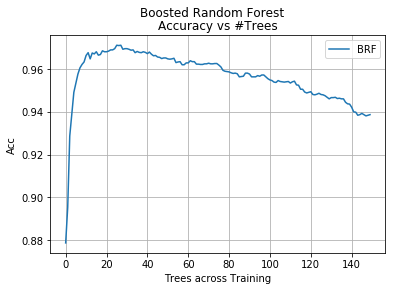

In [53]:
# Calculate mean for the first 150 trees from all BRF classifiers
test_brf_mean_accs = np.mean([ accs[:150] for accs in test_brf_accs ], axis=0)

# Print out results
print("Max acc:, {}, Mean acc: {}".format(max(test_brf_mean_accs), np.mean(test_brf_mean_accs)))

# Plot results
fig, ax1 = plt.subplots()
plt.suptitle("Boosted Random Forest")
plt.title("Accuracy vs #Trees")
ax1.set_xlabel('Trees across Training')

# Accuracy
color = 'tab:blue'
ax1.set_ylabel('Acc')  
ax1.plot(test_brf_mean_accs, color=color, label="BRF")
ax1.tick_params(axis='y')

plt.grid()
plt.legend()
plt.show()


## Comparison with Random Forest
The following figure shows performances of 3 models, with the first two proposed in the referenced paper[1], while the last as a baseline:
- Blue: BRF
- Orange: BRF w/out weight update
- Green: RF

<img src="Plots/pred_acc.png" width="500">

### Observations:
+ BRF obtains the <b><u>highest optimal accuarcy (>97%)</u></b> with <b><u>just 20~30 trees</u></b>!
    - Boosting!
+ BRF has better performance with <b>updated weights</b>
    - Classification power is not the same for all trees
+ RF and BRF w/out weight updates slowly achieve optimal accuracy with more trees 
    - Yet, lower than BRF's best

### Question:
+ <u>Why performance of BRF drops significantly when #trees grows?</u>

### Study on Weighted Errors and Tree Weights
Recall that the weighted errors of trees $\epsilon$ and tree weights $\alpha$ in BRF are given as
- Weighted error (epsilon)
<img src="Pics/epsilon.png" width="200">
- Tree weight (alpha)
<img src="Pics/alpha.png" width="200">

From these two definition, we know:
- Good prediction --> Low error $\epsilon$ --> High weights $\alpha$
- Bad prediction --> High error $\epsilon$ --> Low weights $\alpha$

<br>Even though the under-performing trees are given less significance, <b><u>many small erroneous trees add up to give great influence</u></b> to the final prediction.
<img src="Plots/eps_vs_alpha.png" width="500">

### Quick Thought: How about stopping before garbage trees are trained?
What if we stop training more trees when the weighted errors $\epsilon$'s stop improving? Then a lot of errorneous trees can be removed while retaining well-performing trees only.

Let's study the above figure again. For example, if we stop training at the <span style="color:green"><u>green vertical line</u></span>, then <b>>150</b> trees on the right with high errors can be ignored, while retaining <b>~70</b> trees on the left with better performances. 

This can be achieved by limiting the weighted errors. In the figure, the upper/lower bounds are given by the <span style="color:gray"><u>grey horizontal lines</u></span>. If the <span style="color:orange">error</span> (orange) exceeds the boundaries too much, then there is a high possibility that it will not be improving too much later on, so one can stop the training, and training more trees is not helpful anymore.

# Our Contribution: Early Stopping
In this project, we introduced the use of early stopping for BRF, which is going to be explained in this section. 

## Algorithm
The following gives the modified version of BRF algorithm (with <b><u>modifications bolded and underlined</u></b>):
- for 1:T do
    - train a tree
    - predict with the forest
    - evaluate weighted error $\epsilon$ and tree weights $\alpha$
        - <b><u>If $\epsilon$ exceeds boundaries for too many times</u></b>
            - <b><u>Stop training</u></b>
        - If $\alpha$ > 0 
            - reject tree

## Try Yourself

In [61]:
""" Create a BRF classifier with Early Stopping """
# Set paramters to enable Early Stopping
# Can be easily done by specifying error boundaries and setting 'early_stop' as True
brf_es_params = {'T': 250,
                 'depth_max': 20,
                 'eps_ub': 0.5,
                 'eps_lb': 0,
                 'early_stop': True}
brf_es_clf = BoostedRandomForest(**brf_es_params)

In [64]:
""" Sample Procedures of Experiment """
# Train BRF classifier
start = time()
brf_es_clf.fit(X_train, y_train)
end = time()
print("Training time: ", end-start)

# Give predictions
pred = brf_es_clf.ensemble_predict(X_test)

# Calcuate Accuracy
print("Acc: ", accuracy_score(y_test, pred))

# Get # trees used in classifier
T = len(brf_es_clf.clfs)
print("# Trees: ", T)

Training time:  111.31020283699036
Acc:  0.7341442224152911
# Trees:  255


           
## Improvements
In short, this proposed early stopping algorithm improves BRF with:

1. Retain the nearly optimal set of trees in forest in automated manner
<img src="Plots/early_stop.png" width="400"/>
2. Reduce forest size and hence memory usage
2. Greatly reduce training time
<img src="Pics/table.png" width="600"/>


## Justifacation
Here gives some simple justifications on why the proposed method works.

1. Safely stop after but near a global optimal.
    - Given BRF as a <b>boosting</b> method
        - Possibily attains its optimal at early stage
    - Meanwhile, <b>random sampling</b> in BRF assures comparable performance for testing data
<br><br>
2. Early Stopping can be done on the fly.
    - Similar to 1., performance of BRF tends to drop in one way
<br><br>
3. Introduces lower bounds and upper bound for weighted error.
    - Adding more trees may not be helpful, since
        - "weighted error $\epsilon$ --> 0"         ==> Overfitting (improved too much for training set)
        - "weighted error $\epsilon$ --> 1/n_class" ==> Random Guess (hard to improve more)

## Significance
Given with the properties of BRF (like 1. in previous subsection), the early stopping algorithm proposed here is able to achieve more than the early stopping mechanisms in common place.

The most common practice of early stopping is the validation-based early stopping. The following gives an algorithm excerpted from <a href="https://en.wikipedia.org/wiki/Early_stopping">Wikipedia</a>:
```
1. Split the training data into a training set and a validation set, e.g. in a 2-to-1 proportion.
2. Train only on the training set and evaluate the per-example error on the validation set once in a while, e.g. after every fifth epoch.
3. Stop training as soon as the error on the validation set is higher than it was the last time it was checked.
4. Use the weights the network had in that previous step as the result of the training run.
```
But, some problems are spotted from the algorithm above:
1. How could we ensure the the error is not stuck at local minima?
2. Since validation errors usually fluctuate a lot, how could we distinguish fluctating errors from rising errors?

Usually, the solution is: __TRAIN MORE__ and you will see.
<br><br>
However, with our proposed algorithm, you can stop expanding BRF immediately when the criteria are met.
<br><br>
This discussion is going to be summarized by a comparison between two figures, with the left showing the steps required for picking the best place to stop, and the right showing that with the proposed method.
<br><br>
<img src="Pics/es_comp.png" width="1000"/>
   <div align="center">...............................Validation-based Early Stopping ...................................................................................      BRF with Early Stopping...............................  </div>







# Summary
---
This notebook presented our studies on the algorithm "Boosted Random Forest" [1], which applies Boosting to the bagging algorithm Random Forest, and takes advantages from both methods to give a RF classifier with fewer trees to give better performance. 

For the purpose of the project, BRF is implemented as a python module, which is also used for experiments presented in this notebook. The results do show that BRF does improves on RF in the way as it is designed.

Moreover, this project proposes an improvement to BRF with the use of early stopping. With the proposed improvement, training of BRF classifier can be stopped once its optimal performance is achieved, without sacrifices in accuracy.

For more information about how to use the python module, please refer to example.ipynb for more use cases.

# Reference
---
[1] Mishina, Y., Murata, R., Yamauchi, Y., Yamashita, T., & Fujiyoshi, H. (2015). Boosted random forest. IEICE TRANSACTIONS on Information and Systems, 98(9), 1630-1636.